In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
SOLAR_CAPACITY_KW = 150  
LOAD_PEAK_KW = 100       

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# 1. Load the data
df_solar = pd.read_csv('Plant_1_Generation_Data.csv')

# 2. Fix the Date Format
df_solar['DATE_TIME'] = pd.to_datetime(df_solar['DATE_TIME'], dayfirst=True)

# 3. Aggregate: Sum up all inverters to get TOTAL plant generation at each timestamp
solar_clean = df_solar.groupby('DATE_TIME')['DC_POWER'].sum().reset_index()

# 4. Set Index and Resample
solar_clean.set_index('DATE_TIME', inplace=True)
solar_clean = solar_clean.resample('15T').mean().interpolate()

# 5. Normalize (Scale) for our Project
current_peak = solar_clean['DC_POWER'].max()
solar_clean['solar_kw'] = (solar_clean['DC_POWER'] / current_peak) * SOLAR_CAPACITY_KW

# 6. Keep only the Clean Column
solar_clean = solar_clean[['solar_kw']]

print(f" Solar Data Processed. Rows: {len(solar_clean)}")
solar_clean.head()

 Solar Data Processed. Rows: 3264


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_10384\3110033968.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  solar_clean = solar_clean.resample('15T').mean().interpolate()


,solar_kw
DATE_TIME,
2020-05-15 00:00:00,0.0
2020-05-15 00:15:00,0.0
2020-05-15 00:30:00,0.0
2020-05-15 00:45:00,0.0
2020-05-15 01:00:00,0.0


In [ ]:
# 1. Load the data
df_load = pd.read_csv('smart_grid_dataset.csv')

# 2. Identify and Parse the Date Column
time_col = 'Timestamp' 
if time_col not in df_load.columns:
    time_col = df_load.columns[0]
    print(f" 'Timestamp' column not found. Using first column: '{time_col}'")

df_load[time_col] = pd.to_datetime(df_load[time_col], dayfirst=True, format='mixed')
df_load.set_index(time_col, inplace=True)

# 3. Clean and Resample
load_clean = df_load[['Power Consumption (kW)']].copy()
load_clean.columns = ['load_kw'] 

# Resample to 15 minutes to match Solar data
load_clean = load_clean.resample('15T').mean().interpolate()

# 4. Normalize (Scale)
load_peak = load_clean['load_kw'].max()
load_clean['load_kw'] = (load_clean['load_kw'] / load_peak) * LOAD_PEAK_KW

print(f" Load Data Processed. Rows: {len(load_clean)}")
load_clean.head()

✅ Load Data Processed. Rows: 50000


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_10384\146484996.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  load_clean = load_clean.resample('15T').mean().interpolate()


,load_kw
Timestamp,
2024-01-01 00:00:00,9.843697
2024-01-01 00:15:00,42.086001
2024-01-01 00:30:00,88.900515
2024-01-01 00:45:00,93.546485
2024-01-01 01:00:00,14.010037


In [ ]:
# 1. Shift Solar Year to match Load Year (2020 -> 2024)
solar_clean.index = solar_clean.index.map(lambda t: t.replace(year=2024))

print(f" Solar Data shifted to 2024. Range: {solar_clean.index.min()} to {solar_clean.index.max()}")

# 2. Extend Solar Data (The "Loop" Trick)
solar_list = []
for i in range(12):
    # Copy the data
    temp_df = solar_clean.copy()
    # Shift it forward by 'i' months (approx 30 days * i)
    temp_df.index = temp_df.index + pd.Timedelta(days=34*i)
    solar_list.append(temp_df)

# Combine them into one long solar dataset
solar_extended = pd.concat(solar_list)

# Handle potential duplicates or overlaps from the simple shift
solar_extended = solar_extended[~solar_extended.index.duplicated(keep='first')]

# Resample one last time to ensure clean 15-min index
solar_extended = solar_extended.resample('15T').ffill()

# Update the variable name so the next cell uses this big version
solar_clean = solar_extended

print(f" Solar Data Extended. New Range: {solar_clean.index.min()} to {solar_clean.index.max()}")

✅ Solar Data shifted to 2024. Range: 2024-05-15 00:00:00 to 2024-06-17 23:45:00
✅ Solar Data Extended. New Range: 2024-05-15 00:00:00 to 2025-06-26 23:45:00


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_10384\3851196415.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  solar_extended = solar_extended.resample('15T').ffill()


✅ SUCCESS: Master Dataset Saved as 'grid_data_clean.csv'
                     solar_kw    load_kw  price_per_kwh
2024-05-15 00:00:00       0.0  68.997216           0.12
2024-05-15 00:15:00       0.0  78.285345           0.12
2024-05-15 00:30:00       0.0  71.951884           0.12
2024-05-15 00:45:00       0.0  17.509803           0.12
2024-05-15 01:00:00       0.0  29.697536           0.12


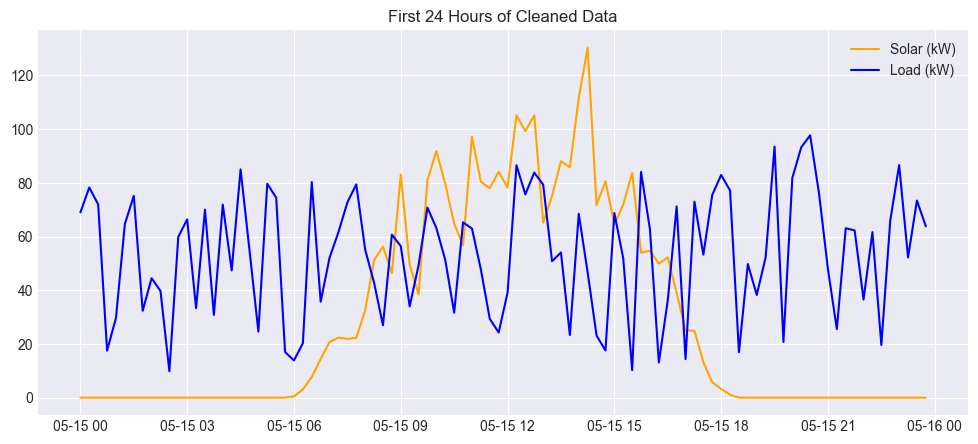

In [ ]:
# 1. Merge (Inner Join)
df_master = pd.merge(solar_clean, load_clean, left_index=True, right_index=True, how='inner')

# 2. Create Pricing (Time of Use Tariff)
# Nigerian Context: High demand in evenings (6PM - 10PM)
df_master['hour'] = df_master.index.hour
df_master['price_per_kwh'] = np.where(
    (df_master['hour'] >= 18) & (df_master['hour'] <= 22), 
    0.50, # Peak Price ($0.50)
    0.12  # Off-Peak Price ($0.12)
)

# 3. Drop helper column
df_master.drop(columns=['hour'], inplace=True)

# 4. Check for Empty Data
if len(df_master) == 0:
    print(" ERROR: The datasets have no overlapping dates! Check your CSV years.")
    print(f"Solar Range: {solar_clean.index.min()} to {solar_clean.index.max()}")
    print(f"Load Range: {load_clean.index.min()} to {load_clean.index.max()}")
else:
    # 5. Save
    df_master.to_csv('grid_data_clean.csv')
    print(" SUCCESS: Master Dataset Saved as 'grid_data_clean.csv'")
    print(df_master.head())
    
    # 6. Final Visualization check
    plt.figure(figsize=(12, 5))
    plt.plot(df_master.index[:96], df_master['solar_kw'][:96], label='Solar (kW)', color='orange')
    plt.plot(df_master.index[:96], df_master['load_kw'][:96], label='Load (kW)', color='blue')
    plt.title("First 24 Hours of Cleaned Data")
    plt.legend()
    plt.show()